In [1]:
import os
import numpy as np
from geopy import distance
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
import sys
sys.path.append('./code')
from stack_image import StackedImageDataset, SingleImageDataset
from model import StreetViewNet
from args import args

In [2]:
train_data_path = './processed/train'
val_data_path = './processed/val'

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda:1


In [4]:
standard_transform = transforms.Compose([
    transforms.RandomCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = SingleImageDataset(val_data_path, transform=standard_transform)
model = StreetViewNet().to(device)
class_lossfn = CrossEntropyLoss()

checkpoint = torch.load('./code/trained_models/10-31-14-05/model-49.pth')
model.load_state_dict(checkpoint['model_state_dict'])



RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.384591].


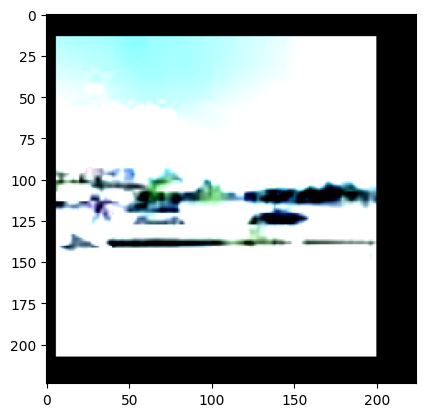

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.037863124].


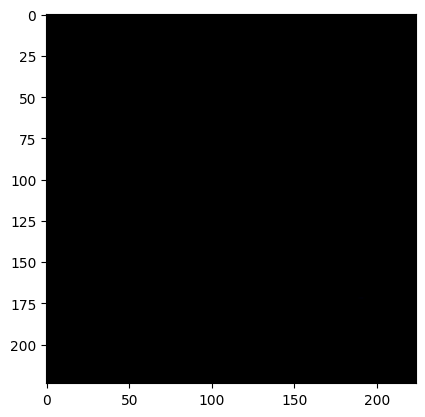

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


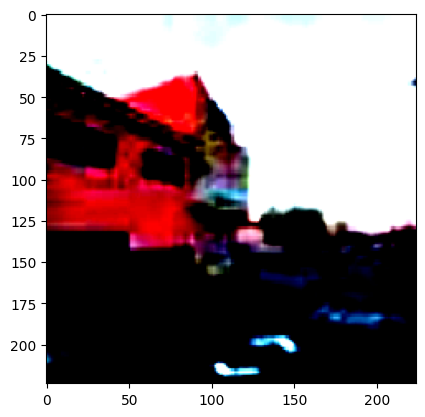

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.64742076].


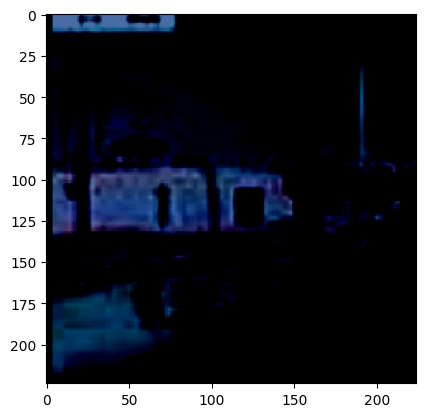

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.6838482].


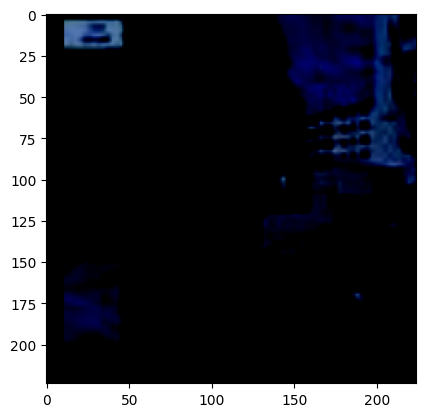

In [6]:
# Check augmentation

transform = transforms.Compose([
    transforms.RandomCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = SingleImageDataset(train_data_path, transform=transform)
sample_indices = np.random.choice(len(train_dataset), 5)
subset = Subset(train_dataset, sample_indices)
for img, label  in DataLoader(subset, batch_size=1):
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()

In [14]:
val_loss = 0
correct_pred = 0 
with torch.no_grad():
    for img, label in DataLoader(val_dataset, batch_size=args.batch_size):
        img = img.to(device)
        label = label.to(device).long()
        # class_label, reg_label = label
        # class_label = class_label.to(device)
        # reg_label = reg_label.to(device)
        class_pred = model(img) 
        class_loss = class_lossfn(class_pred, label)
        # reg_loss = reg_lossfn(reg_pred, reg_label)
        # total_loss = (class_loss + args.alpha * reg_loss)
        val_loss += class_loss.item()
        correct_pred += (class_pred.argmax(dim=1) == label).sum().item()
print(f"val_loss: {val_loss / len(val_dataset)}")
print(f"val_acc: {correct_pred / len(val_dataset)}")

val_loss: 0.0661765387566153
val_acc: 0.4611094512498755
